In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

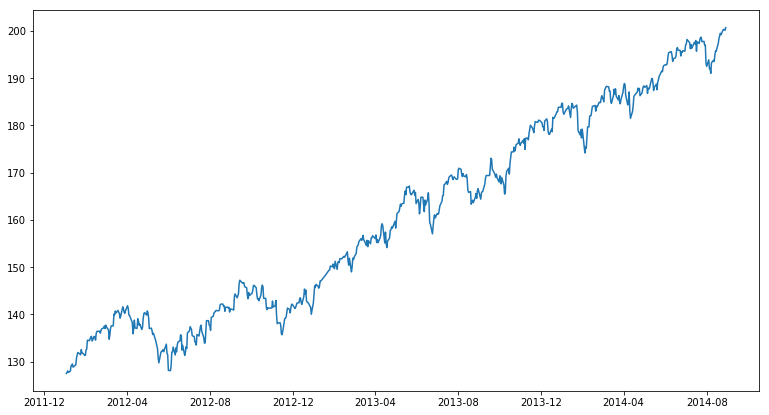

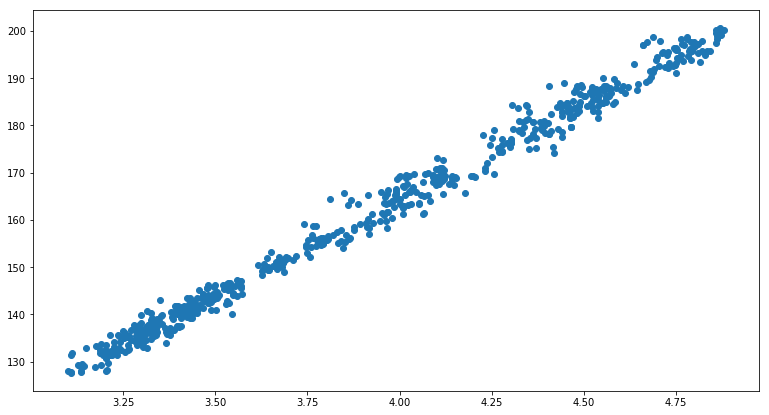

In [118]:
# I am replacing outliers instead of dropping for sake of window
df = pd.read_csv("stockdata.csv", index_col='date', parse_dates=['date'])

# Replace signal outliers with last observation
sig_val = df['signal'].value_counts()
criteria = df[ (df['signal'] <= 2) | (df['signal'] >= 400) ]
df['signal'][criteria.index] = np.nan
df['signal'].fillna(method='ffill', inplace=True)

# Replace spy_close_price outliers with last observation
sig_val = df['spy_close_price'].value_counts()
criteria = df[ df['spy_close_price'] >= 500 ]
df['spy_close_price'][criteria.index] = np.nan
df['spy_close_price'].fillna(method='ffill', inplace=True)



plt.figure(figsize=(13,7))
plt.plot(df['spy_close_price'])
plt.show()

plt.figure(figsize=(13,7))
plt.scatter(df['signal'], df['spy_close_price'])
plt.show() 

In [119]:
def test_stationarity(timeseries, window=21):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window, center=False).mean()#  window=pd.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling(window, center=False).std() # pd.rolling_std(timeseries, window=12)
    

    #Plot rolling statistics:
    plt.figure(figsize=(15,10))
    orig = plt.plot(timeseries, color='blue',label='Original', linewidth=1)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=1)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std', linewidth=1)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

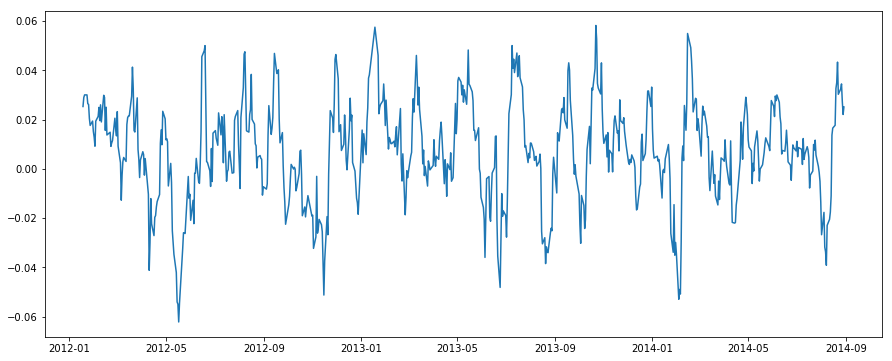

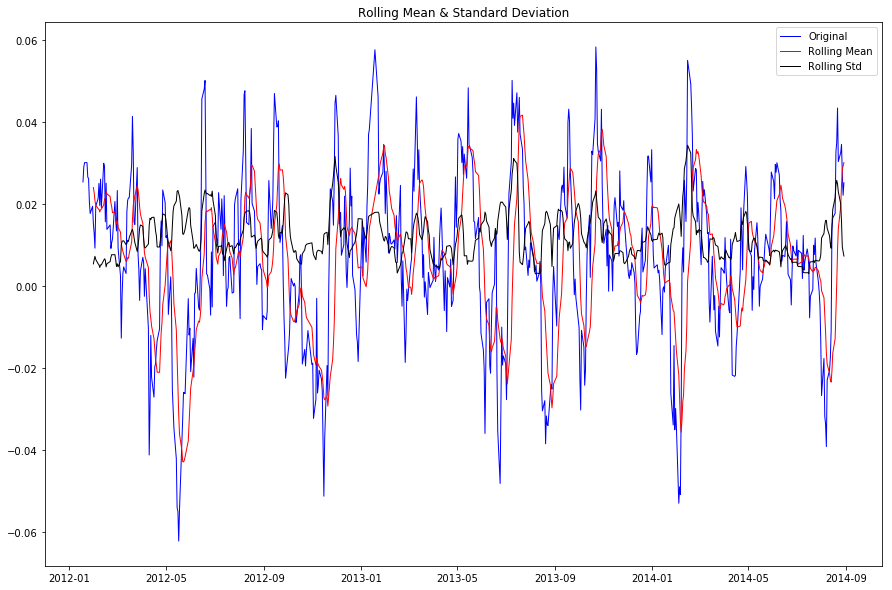

Results of Dickey-Fuller Test:
Test Statistic                  -5.023633
p-value                          0.000020
#Lags Used                      20.000000
Number of Observations Used    636.000000
Critical Value (1%)             -3.440674
Critical Value (5%)             -2.866095
Critical Value (10%)            -2.569196
dtype: float64


In [121]:
from statsmodels.tsa.stattools import adfuller
from pandas.core import datetools
from statsmodels.tsa.arima_model import ARIMA

# sliding window size to simulate 2 weeks ( 10 days )
wind=10

# Price log diff
price_log = np.log(df['spy_close_price'])
price_log_dif = price_log - price_log.shift(periods=wind)
price_log_dif.dropna(inplace=True)

plt.figure(figsize=(15,6))
plt.plot(price_log_dif)
test_stationarity(price_log_dif, wind)

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


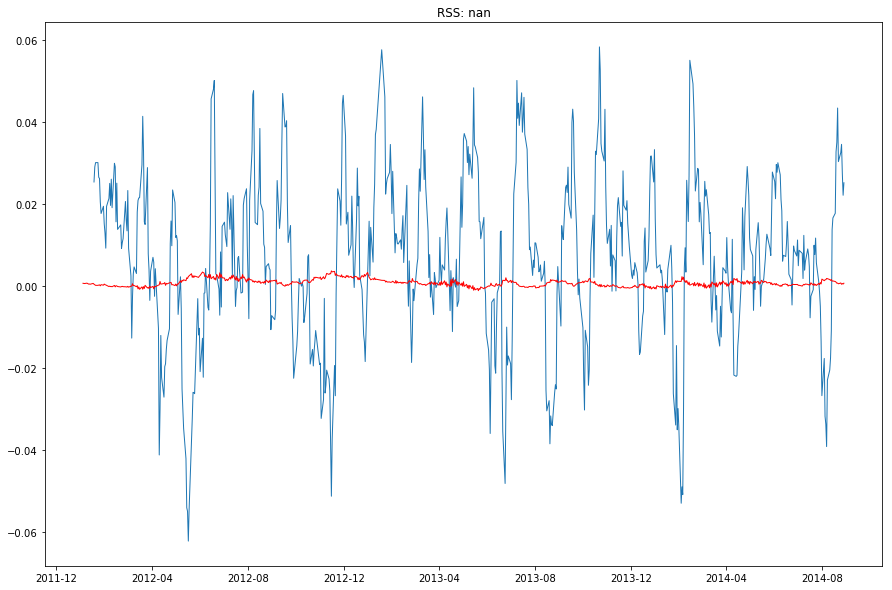

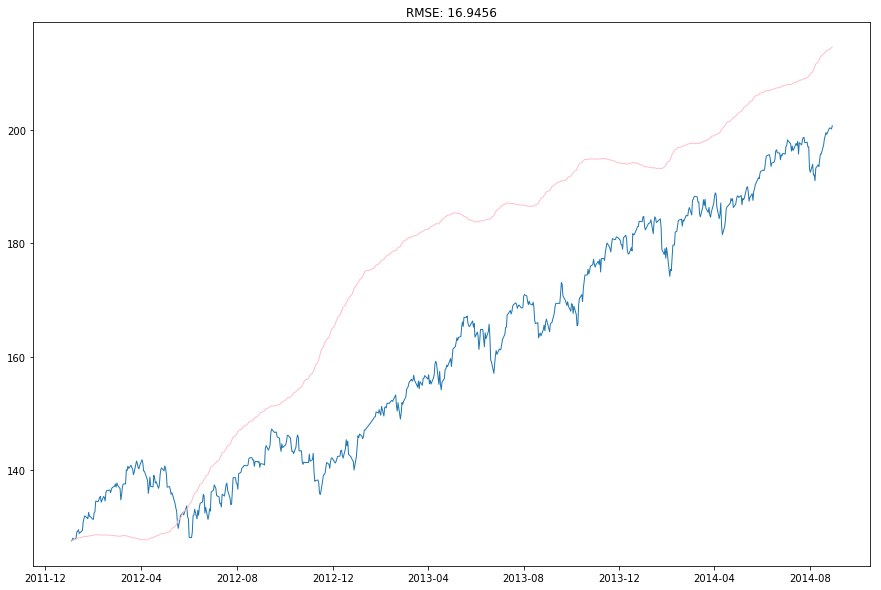

In [122]:
# OK EVERYTHING AFTER THIS POINT IS USELESS .-. 
# Should use another model for it and not arima 
# I guess, or I'm probably just doing it wrong.

# Model ARIMA combined model
model = ARIMA(price_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1, maxiter=100)

plt.figure(figsize=(15,10))
plt.plot(price_log_dif, linewidth=1)
plt.plot(results_ARIMA.fittedvalues, color='red', linewidth=1)
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-price_log_dif)**2))


# Transform back into original and plot
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

predictions_ARIMA_log = pd.Series(price_log.iloc[0], index=price_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

predictions_ARIMA = np.exp(predictions_ARIMA_log)

# Look how bad the prediction is :( 
plt.figure(figsize=(15,10))
plt.plot(df['spy_close_price'], linewidth=1)
plt.plot(predictions_ARIMA, linewidth=1, color='pink')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df['spy_close_price'])**2)/len(df['spy_close_price'])))
plt.show()